# DETR Balloon Dataset ファインチューニング - Google Colab版

このノートブックでは、DETRモデルをBalloon Dataset（風船検出）でファインチューニングします。

**特徴:**
- データセットの自動ダウンロードと準備
- Google Colabでそのまま実行可能
- 1クラス物体検出（風船）
- COCO形式のアノテーションを使用


## 1. 必要なライブラリのインストール


In [1]:
!pip install transformers torch torchvision pillow matplotlib requests datasets accelerate -q


## 2. GPUの確認


In [2]:
# GPUの確認
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("警告: GPUが利用できません。ColabでGPUを有効にしてください: Runtime > Change runtime type > GPU")


CUDA available: True
GPU: Tesla T4
CUDA version: 12.6


## 3. Balloon Datasetのダウンロードと準備


In [3]:
import os
import json
import requests
import zipfile
from pathlib import Path
from PIL import Image
import shutil

# 作業ディレクトリの設定（Google Colabの場合は/content、それ以外は現在のディレクトリ）
# ディレクトリが存在しない場合は作成
if os.path.exists('/content'):
    work_dir = '/content'
else:
    # /contentが存在しない場合、作成を試みる
    try:
        os.makedirs('/content', exist_ok=True)
        work_dir = '/content'
        print("警告: /contentディレクトリを作成しました")
    except PermissionError:
        # 権限がない場合は、ホームディレクトリまたは一時ディレクトリを使用
        work_dir = os.path.expanduser('~')
        print(f"警告: /contentにアクセスできません。ホームディレクトリを使用します: {work_dir}")

# 作業ディレクトリに移動（存在することを確認）
try:
    os.chdir(work_dir)
except (FileNotFoundError, PermissionError) as e:
    # 移動できない場合は、現在のディレクトリを確認
    try:
        current_dir = os.getcwd()
        work_dir = current_dir
        print(f"警告: ディレクトリ移動に失敗しました。現在のディレクトリを使用: {work_dir}")
    except FileNotFoundError:
        # それでも失敗する場合は、一時ディレクトリを使用
        import tempfile
        work_dir = tempfile.gettempdir()
        print(f"警告: 作業ディレクトリが見つかりません。一時ディレクトリを使用: {work_dir}")

# データセットのダウンロードURL（MatterportのBalloon Dataset）
DATASET_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"
DATASET_DIR = work_dir  # 作業ディレクトリを使用
ZIP_FILE = os.path.join(work_dir, "balloon_dataset.zip")

# 既存のデータセットをクリーンアップ（再実行時用）
balloon_path = os.path.join(DATASET_DIR, "balloon")
if os.path.exists(balloon_path):
    shutil.rmtree(balloon_path)
if os.path.exists(ZIP_FILE):
    os.remove(ZIP_FILE)

print(f"作業ディレクトリ: {work_dir}")
print(f"データセット保存先: {DATASET_DIR}")
print("Balloon Datasetをダウンロード中...")

response = requests.get(DATASET_URL, stream=True)
total_size = int(response.headers.get('content-length', 0))
downloaded = 0

# ZIPファイルの保存先ディレクトリが存在することを確認
os.makedirs(work_dir, exist_ok=True)

with open(ZIP_FILE, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)
            downloaded += len(chunk)
            if total_size > 0:
                percent = (downloaded / total_size) * 100
                print(f"\rダウンロード進捗: {percent:.1f}%", end='', flush=True)

print(f"\nダウンロード完了: {ZIP_FILE}")

# ZIPファイルを展開
print("データセットを展開中...")
with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(DATASET_DIR)

print("データセットの準備が完了しました！")
print(f"現在の作業ディレクトリ: {os.getcwd()}")
print(f"データセットディレクトリ: {DATASET_DIR}")

作業ディレクトリ: /content
データセット保存先: /content
Balloon Datasetをダウンロード中...
ダウンロード進捗: 100.0%
ダウンロード完了: /content/balloon_dataset.zip
データセットを展開中...
データセットの準備が完了しました！
現在の作業ディレクトリ: /content
データセットディレクトリ: /content


In [4]:
# データセット構造の確認
balloon_dir = os.path.join(DATASET_DIR, "balloon")
train_dir = os.path.join(balloon_dir, "train")
val_dir = os.path.join(balloon_dir, "val")

print("データセット構造:")
print(f"  - {balloon_dir}")
if os.path.exists(train_dir):
    train_images = [f for f in os.listdir(train_dir) if f.endswith(('.jpg', '.png'))]
    print(f"  - トレーニング画像: {len(train_images)}枚")

    # VIA形式のアノテーションファイルを探す
    via_files = [f for f in os.listdir(train_dir) if f.endswith('.json')]
    if via_files:
        print(f"  - アノテーションファイル: {via_files[0]}")

if os.path.exists(val_dir):
    val_images = [f for f in os.listdir(val_dir) if f.endswith(('.jpg', '.png'))]
    print(f"  - バリデーション画像: {len(val_images)}枚")


データセット構造:
  - /content/balloon
  - トレーニング画像: 61枚
  - アノテーションファイル: via_region_data.json
  - バリデーション画像: 13枚


## 4. VIA形式からCOCO形式への変換

Balloon DatasetはVIA形式のアノテーションを使用しているため、COCO形式に変換します。


In [5]:
def convert_via_to_coco(via_json_path, images_dir, output_json_path, split_name="train"):
    """
    VIA形式のアノテーションをCOCO形式に変換

    Args:
        via_json_path: VIA形式のJSONファイルパス
        images_dir: 画像ディレクトリ
        output_json_path: 出力するCOCO形式JSONファイルパス
        split_name: データセット分割名（train/val）
    """
    # VIA形式のJSONを読み込み
    with open(via_json_path, 'r', encoding='utf-8') as f:
        via_data = json.load(f)

    # COCO形式の構造を作成
    coco_data = {
        "info": {
            "description": "Balloon Dataset",
            "version": "1.0",
            "year": 2024
        },
        "licenses": [],
        "categories": [
            {
                "id": 1,
                "name": "balloon",
                "supercategory": "object"
            }
        ],
        "images": [],
        "annotations": []
    }

    # 画像ファイルを取得
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.JPG', '.PNG'))]

    image_id = 1
    annotation_id = 1

    # VIAデータを処理
    for filename, file_data in via_data.items():
        # ファイル名の正規化（VIA形式ではファイル名がキーになっている）
        if isinstance(file_data, dict) and "filename" in file_data:
            actual_filename = file_data["filename"]
        else:
            actual_filename = filename

        if not actual_filename.endswith(('.jpg', '.png', '.JPG', '.PNG', '.jpeg', '.JPEG')):
            continue

        # 画像情報を追加
        image_path = os.path.join(images_dir, actual_filename)
        if not os.path.exists(image_path):
            # ファイル名の大文字小文字を無視して再試行
            found_file = None
            for img_file in os.listdir(images_dir):
                if img_file.lower() == actual_filename.lower():
                    found_file = img_file
                    break
            if found_file:
                image_path = os.path.join(images_dir, found_file)
                actual_filename = found_file
            else:
                print(f"警告: 画像が見つかりません: {actual_filename}")
                continue

        try:
            # 画像サイズを取得
            img = Image.open(image_path)
            width, height = img.size
        except Exception as e:
            print(f"警告: 画像を読み込めませんでした {actual_filename}: {e}")
            continue

        coco_data["images"].append({
            "id": image_id,
            "file_name": actual_filename,
            "width": width,
            "height": height
        })

        # アノテーションを処理
        regions = file_data.get("regions", {})
        if not regions:
            # アノテーションがない画像も追加（空のアノテーション）
            pass

        for region_key, region_data in regions.items():
            if not isinstance(region_data, dict):
                continue

            shape_attributes = region_data.get("shape_attributes", {})
            region_attributes = region_data.get("region_attributes", {})

            # ポリゴンまたは矩形の処理
            if "all_points_x" in shape_attributes and "all_points_y" in shape_attributes:
                try:
                    # ポリゴンからバウンディングボックスを計算
                    x_points = shape_attributes["all_points_x"]
                    y_points = shape_attributes["all_points_y"]

                    if len(x_points) < 3 or len(y_points) < 3:
                        continue  # 有効なポリゴンではない

                    x_min = max(0, min(x_points))
                    y_min = max(0, min(y_points))
                    x_max = min(width, max(x_points))
                    y_max = min(height, max(y_points))

                    bbox_width = x_max - x_min
                    bbox_height = y_max - y_min

                    # 有効なバウンディングボックスかチェック
                    if bbox_width <= 0 or bbox_height <= 0:
                        continue

                    area = bbox_width * bbox_height

                    # COCO形式のアノテーションを追加
                    coco_data["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": 1,  # balloon
                        "bbox": [x_min, y_min, bbox_width, bbox_height],
                        "area": area,
                        "iscrowd": 0
                    })

                    annotation_id += 1
                except Exception as e:
                    print(f"警告: アノテーション処理エラー (画像: {actual_filename}): {e}")
                    continue

        image_id += 1

    # COCO形式のJSONを保存
    os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(coco_data, f, indent=2, ensure_ascii=False)

    print(f"COCO形式に変換完了: {output_json_path}")
    print(f"  - 画像数: {len(coco_data['images'])}")
    print(f"  - アノテーション数: {len(coco_data['annotations'])}")

    return coco_data

# トレーニングデータの変換
balloon_dir = os.path.join(DATASET_DIR, "balloon")
train_dir = os.path.join(balloon_dir, "train")

# VIA形式のJSONファイルを探す
via_files = [f for f in os.listdir(train_dir) if f.endswith('.json')]
if via_files:
    via_json_path = os.path.join(train_dir, via_files[0])
    train_coco_path = os.path.join(DATASET_DIR, "annotations", "train_annotations.json")
    train_coco = convert_via_to_coco(via_json_path, train_dir, train_coco_path, "train")
else:
    print("警告: VIA形式のアノテーションファイルが見つかりません。")
    print("既存のCOCO形式アノテーションを探します...")


COCO形式に変換完了: /content/annotations/train_annotations.json
  - 画像数: 61
  - アノテーション数: 255


In [6]:
# バリデーションデータの処理（存在する場合）
val_dir = os.path.join(balloon_dir, "val")
if os.path.exists(val_dir):
    via_files_val = [f for f in os.listdir(val_dir) if f.endswith('.json')]
    if via_files_val:
        via_json_path_val = os.path.join(val_dir, via_files_val[0])
        val_coco_path = os.path.join(DATASET_DIR, "annotations", "val_annotations.json")
        val_coco = convert_via_to_coco(via_json_path_val, val_dir, val_coco_path, "val")
    else:
        print("バリデーションデータのVIA形式ファイルが見つかりません。")
        # トレーニングデータから分割する場合
        print("トレーニングデータから80%をトレーニング、20%をバリデーションに分割します...")

        # トレーニングデータを読み込み
        with open(train_coco_path, 'r', encoding='utf-8') as f:
            full_coco = json.load(f)

        # 画像IDでシャッフルして分割
        import random
        random.seed(42)
        image_ids = [img['id'] for img in full_coco['images']]
        random.shuffle(image_ids)

        split_idx = int(len(image_ids) * 0.8)
        train_ids = set(image_ids[:split_idx])
        val_ids = set(image_ids[split_idx:])

        # トレーニングデータセットを作成
        train_coco_split = {
            "info": full_coco["info"],
            "licenses": full_coco["licenses"],
            "categories": full_coco["categories"],
            "images": [img for img in full_coco['images'] if img['id'] in train_ids],
            "annotations": [ann for ann in full_coco['annotations'] if ann['image_id'] in train_ids]
        }

        # バリデーションデータセットを作成
        val_coco_split = {
            "info": full_coco["info"],
            "licenses": full_coco["licenses"],
            "categories": full_coco["categories"],
            "images": [img for img in full_coco['images'] if img['id'] in val_ids],
            "annotations": [ann for ann in full_coco['annotations'] if ann['image_id'] in val_ids]
        }

        # 保存
        train_coco_path = os.path.join(DATASET_DIR, "annotations", "train_annotations.json")
        val_coco_path = os.path.join(DATASET_DIR, "annotations", "val_annotations.json")

        with open(train_coco_path, 'w', encoding='utf-8') as f:
            json.dump(train_coco_split, f, indent=2, ensure_ascii=False)

        with open(val_coco_path, 'w', encoding='utf-8') as f:
            json.dump(val_coco_split, f, indent=2, ensure_ascii=False)

        print(f"データ分割完了:")
        print(f"  - トレーニング: {len(train_coco_split['images'])}枚")
        print(f"  - バリデーション: {len(val_coco_split['images'])}枚")
else:
    # バリデーションデータがない場合、トレーニングデータから分割
    print("バリデーションデータが見つかりません。トレーニングデータから分割します...")

    with open(train_coco_path, 'r', encoding='utf-8') as f:
        full_coco = json.load(f)

    import random
    random.seed(42)
    image_ids = [img['id'] for img in full_coco['images']]
    random.shuffle(image_ids)

    split_idx = int(len(image_ids) * 0.8)
    train_ids = set(image_ids[:split_idx])
    val_ids = set(image_ids[split_idx:])

    train_coco_split = {
        "info": full_coco["info"],
        "licenses": full_coco["licenses"],
        "categories": full_coco["categories"],
        "images": [img for img in full_coco['images'] if img['id'] in train_ids],
        "annotations": [ann for ann in full_coco['annotations'] if ann['image_id'] in train_ids]
    }

    val_coco_split = {
        "info": full_coco["info"],
        "licenses": full_coco["licenses"],
        "categories": full_coco["categories"],
        "images": [img for img in full_coco['images'] if img['id'] in val_ids],
        "annotations": [ann for ann in full_coco['annotations'] if ann['image_id'] in val_ids]
    }

    val_coco_path = os.path.join(DATASET_DIR, "annotations", "val_annotations.json")

    with open(train_coco_path, 'w', encoding='utf-8') as f:
        json.dump(train_coco_split, f, indent=2, ensure_ascii=False)

    with open(val_coco_path, 'w', encoding='utf-8') as f:
        json.dump(val_coco_split, f, indent=2, ensure_ascii=False)

    print(f"データ分割完了:")
    print(f"  - トレーニング: {len(train_coco_split['images'])}枚")
    print(f"  - バリデーション: {len(val_coco_split['images'])}枚")


COCO形式に変換完了: /content/annotations/val_annotations.json
  - 画像数: 13
  - アノテーション数: 50


## 5. 設定とインポート


In [7]:
import os
import json
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset
from transformers import (
    DetrImageProcessor,
    DetrForObjectDetection,
    TrainingArguments,
    Trainer
)
import numpy

# 設定
PRETRAINED_MODEL = "facebook/detr-resnet-50"
# DATASET_DIRを、実際のデータセットが展開されたルートディレクトリに修正
DATASET_DIR = "/content"
TRAIN_ANNOTATIONS_PATH = os.path.join(DATASET_DIR, "annotations", "train_annotations.json")
VAL_ANNOTATIONS_PATH = os.path.join(DATASET_DIR, "annotations", "val_annotations.json")
IMAGES_DIR = os.path.join(DATASET_DIR, "balloon", "train")  # 画像ディレクトリもDATASET_DIRを基に修正
OUTPUT_DIR = "outputs"

# カスタムクラス設定（Balloon Datasetは1クラス）
NUM_LABELS = 1
ID2LABEL = {0: "background", 1: "balloon"}  # DETRは0が背景、1からがクラス
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

print("設定を読み込みました")
print(f"トレーニングアノテーション: {TRAIN_ANNOTATIONS_PATH}")
print(f"バリデーションアノテーション: {VAL_ANNOTATIONS_PATH}")
print(f"画像ディレクトリ: {IMAGES_DIR}")

設定を読み込みました
トレーニングアノテーション: /content/annotations/train_annotations.json
バリデーションアノテーション: /content/annotations/val_annotations.json
画像ディレクトリ: /content/balloon/train


## 6. データセットクラスの定義


In [8]:
class CocoDetection(Dataset):
    """COCO形式のデータセットクラス"""

    def __init__(self, image_processor, data_dir, annotation_file, train=True):
        """
        Args:
            image_processor: DetrImageProcessor
            data_dir: 画像ディレクトリのパス
            annotation_file: COCO形式のJSONファイルパス
            train: トレーニングモードかどうか（データ拡張の有無）
        """
        self.image_processor = image_processor
        self.data_dir = data_dir
        self.train = train

        # アノテーションファイルを読み込み
        with open(annotation_file, 'r', encoding='utf-8') as f:
            self.coco = json.load(f)

        # 画像IDとファイル名のマッピング
        self.id2filename = {img['id']: img['file_name'] for img in self.coco['images']}

        # 画像IDごとのアノテーションをグループ化
        self.annotations = {}
        for ann in self.coco['annotations']:
            image_id = ann['image_id']
            if image_id not in self.annotations:
                self.annotations[image_id] = []
            self.annotations[image_id].append(ann)

        # 画像IDのリスト
        self.image_ids = list(self.id2filename.keys())

        print(f"データセットを読み込みました: {len(self.image_ids)}枚の画像")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        filename = self.id2filename[image_id]
        image_path = os.path.join(self.data_dir, filename)

        # 画像を読み込み
        image = Image.open(image_path).convert('RGB')

        # アノテーションを取得
        annotations = self.annotations.get(image_id, [])

        # COCO形式のターゲットを作成
        # DetrImageProcessorはimage_idを整数として期待する
        target = {
            'image_id': image_id,  # 整数として保存
            'annotations': []
        }

        # 画像を前処理（annotationsは渡さない）
        encoding = self.image_processor(
            images=image,
            return_tensors="pt"
        )

        # バッチ次元を削除
        pixel_values = encoding['pixel_values'].squeeze(0)

        # 画像サイズを取得（元のサイズ）
        orig_width, orig_height = image.size

        # DetrImageProcessorがリサイズしたサイズを取得
        # pixel_valuesの形状から推測（通常は800x800にリサイズされる）
        processed_height, processed_width = pixel_values.shape[-2:]

        # labelsを手動で作成
        if annotations:
            # バウンディングボックスを正規化
            boxes_list = []
            for ann in annotations:
                bbox = ann['bbox']  # [x_min, y_min, width, height]
                # [x_min, y_min, width, height]から[x_center, y_center, width, height]に変換し、正規化
                x_center = (bbox[0] + bbox[2] / 2) / orig_width
                y_center = (bbox[1] + bbox[3] / 2) / orig_height
                width_norm = bbox[2] / orig_width
                height_norm = bbox[3] / orig_height
                boxes_list.append([x_center, y_center, width_norm, height_norm])

            labels = {
                'image_id': torch.tensor(image_id, dtype=torch.int64),
                'class_labels': torch.tensor([ann['category_id'] for ann in annotations], dtype=torch.int64),
                'boxes': torch.tensor(boxes_list, dtype=torch.float32),
                'area': torch.tensor([ann['area'] for ann in annotations], dtype=torch.float32),
                'iscrowd': torch.tensor([ann.get('iscrowd', 0) for ann in annotations], dtype=torch.int64),
                'orig_size': torch.tensor([orig_height, orig_width], dtype=torch.int64),
                'size': torch.tensor([processed_height, processed_width], dtype=torch.int64)
            }
        else:
            # アノテーションがない場合
            labels = {
                'image_id': torch.tensor(image_id, dtype=torch.int64),
                'class_labels': torch.tensor([], dtype=torch.int64),
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'area': torch.tensor([], dtype=torch.float32),
                'iscrowd': torch.tensor([], dtype=torch.int64),
                'orig_size': torch.tensor([orig_height, orig_width], dtype=torch.int64),
                'size': torch.tensor([processed_height, processed_width], dtype=torch.int64)
            }

        return {
            'pixel_values': pixel_values,
            'labels': labels
        }

## 7. モデルとプロセッサの読み込み


In [9]:
# プロセッサの読み込み
# formatパラメータを明示的に指定
image_processor = DetrImageProcessor.from_pretrained(PRETRAINED_MODEL, format="coco_detection")

# モデルの読み込み
# 注意: DETRは背景クラスを含むため、num_labelsは実際のクラス数+1
# Balloon Datasetは1クラスなので、num_labels=2（背景+balloon）
model = DetrForObjectDetection.from_pretrained(
    PRETRAINED_MODEL,
    num_labels=2,  # 背景(0) + balloon(1)
    ignore_mismatched_sizes=True
)

# カスタムラベル設定
model.config.id2label = {0: "background", 1: "balloon"}
model.config.label2id = {"background": 0, "balloon": 1}

# GPUに移動
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"モデルを読み込みました: {PRETRAINED_MODEL}")
print(f"デバイス: {device}")
print(f"クラス数: 2 (background + balloon)")
print(f"クラス: {list(model.config.id2label.values())}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

モデルを読み込みました: facebook/detr-resnet-50
デバイス: cuda
クラス数: 2 (background + balloon)
クラス: ['background', 'balloon']


## 8. データセットの読み込み


In [10]:
# トレーニングデータセット
train_dataset = CocoDetection(
    image_processor=image_processor,
    data_dir=IMAGES_DIR,
    annotation_file='/content/annotations/train_annotations.json',
    train=True
)

# バリデーションデータセット
# バリデーション画像もtrainディレクトリにある場合があるため、画像パスを動的に解決
def get_image_path(image_id, filename):
    """画像パスを動的に解決"""
    # まずtrainディレクトリを確認
    train_path = os.path.join(DATASET_DIR, "balloon", "train", filename)
    if os.path.exists(train_path):
        return os.path.join(DATASET_DIR, "balloon", "train")
    # 次にvalディレクトリを確認
    val_path = os.path.join(DATASET_DIR, "balloon", "val", filename)
    if os.path.exists(val_path):
        return os.path.join(DATASET_DIR, "balloon", "val")
    # デフォルトはtrainディレクトリ
    return os.path.join(DATASET_DIR, "balloon", "train")

# バリデーションデータセット用のカスタムクラス
class CocoDetectionVal(CocoDetection):
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        filename = self.id2filename[image_id]
        image_dir = get_image_path(image_id, filename)
        image_path = os.path.join(image_dir, filename)

        image = Image.open(image_path).convert('RGB')
        annotations = self.annotations.get(image_id, [])

        target = {
            'image_id': image_id,  # torch.tensorではなく通常のint型
            'annotations': []
        }

        # 画像を前処理（annotationsは渡さない）
        encoding = self.image_processor(
            images=image,
            return_tensors="pt"
        )

        # バッチ次元を削除
        pixel_values = encoding['pixel_values'].squeeze(0)

        # 画像サイズを取得（元のサイズ）
        orig_width, orig_height = image.size

        # DetrImageProcessorがリサイズしたサイズを取得
        # pixel_valuesの形状から推測（通常は800x800にリサイズされる）
        processed_height, processed_width = pixel_values.shape[-2:]

        # labelsを手動で作成
        if annotations:
            # バウンディングボックスを正規化
            boxes_list = []
            for ann in annotations:
                bbox = ann['bbox']  # [x_min, y_min, width, height]
                # [x_min, y_min, width, height]から[x_center, y_center, width, height]に変換し、正規化
                x_center = (bbox[0] + bbox[2] / 2) / orig_width
                y_center = (bbox[1] + bbox[3] / 2) / orig_height
                width_norm = bbox[2] / orig_width
                height_norm = bbox[3] / orig_height
                boxes_list.append([x_center, y_center, width_norm, height_norm])

            labels = {
                'image_id': torch.tensor(image_id, dtype=torch.int64),
                'class_labels': torch.tensor([ann['category_id'] for ann in annotations], dtype=torch.int64),
                'boxes': torch.tensor(boxes_list, dtype=torch.float32),
                'area': torch.tensor([ann['area'] for ann in annotations], dtype=torch.float32),
                'iscrowd': torch.tensor([ann.get('iscrowd', 0) for ann in annotations], dtype=torch.int64),
                'orig_size': torch.tensor([orig_height, orig_width], dtype=torch.int64),
                'size': torch.tensor([processed_height, processed_width], dtype=torch.int64)
            }
        else:
            # アノテーションがない場合
            labels = {
                'image_id': torch.tensor(image_id, dtype=torch.int64),
                'class_labels': torch.tensor([], dtype=torch.int64),
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'area': torch.tensor([], dtype=torch.float32),
                'iscrowd': torch.tensor([], dtype=torch.int64),
                'orig_size': torch.tensor([orig_height, orig_width], dtype=torch.int64),
                'size': torch.tensor([processed_height, processed_width], dtype=torch.int64)
            }

        return {
            'pixel_values': pixel_values,
            'labels': labels
        }

val_dataset = CocoDetectionVal(
    image_processor=image_processor,
    data_dir=IMAGES_DIR,  # ベースパス（実際のパス解決は__getitem__で行う）
    annotation_file=VAL_ANNOTATIONS_PATH,
    train=False
)

print(f"\nトレーニングデータ: {len(train_dataset)}枚")
print(f"バリデーションデータ: {len(val_dataset)}枚")

データセットを読み込みました: 61枚の画像
データセットを読み込みました: 13枚の画像

トレーニングデータ: 61枚
バリデーションデータ: 13枚


In [11]:
# デバッグ: データセットの構造を確認
print("=== データセット構造の確認 ===")

# まず、target辞書の構造を確認
image_id = train_dataset.image_ids[0]
annotations = train_dataset.annotations.get(image_id, [])
print(f"\n画像ID {image_id}のアノテーション数: {len(annotations)}")

# target辞書を作成して構造を確認
target = {
    'image_id': image_id,
    'annotations': []
}

for ann in annotations:
    target['annotations'].append({
        'bbox': ann['bbox'],
        'category_id': ann['category_id'],
        'area': ann['area'],
        'iscrowd': ann.get('iscrowd', 0)
    })

print(f"\ntarget辞書の構造:")
print(f"  image_id: {target['image_id']} (type: {type(target['image_id'])})")
print(f"  annotations: {len(target['annotations'])}個")
if target['annotations']:
    print(f"  最初のアノテーション: {target['annotations'][0]}")
    print(f"  アノテーションのキー: {target['annotations'][0].keys()}")

# DetrImageProcessorに渡す前に検証
print(f"\nDetrImageProcessorに渡すtarget:")
print(f"  type: {type(target)}")
print(f"  keys: {target.keys()}")
print(f"  image_id type: {type(target['image_id'])}")
print(f"  annotations type: {type(target['annotations'])}")
print(f"  annotations length: {len(target['annotations'])}")

# 実際にデータセットから取得してみる
try:
    sample_idx = 0
    sample = train_dataset[sample_idx]
    print(f"\n✓ データセットの読み込みに成功しました！")
    print(f"  pixel_values shape: {sample['pixel_values'].shape}")
    print(f"  labels type: {type(sample['labels'])}")
except Exception as e:
    print(f"\n✗ エラーが発生しました: {e}")
    print(f"  エラータイプ: {type(e).__name__}")
    import traceback
    traceback.print_exc()


=== データセット構造の確認 ===

画像ID 1のアノテーション数: 1

target辞書の構造:
  image_id: 1 (type: <class 'int'>)
  annotations: 1個
  最初のアノテーション: {'bbox': [994, 619, 451, 547], 'category_id': 1, 'area': 246697, 'iscrowd': 0}
  アノテーションのキー: dict_keys(['bbox', 'category_id', 'area', 'iscrowd'])

DetrImageProcessorに渡すtarget:
  type: <class 'dict'>
  keys: dict_keys(['image_id', 'annotations'])
  image_id type: <class 'int'>
  annotations type: <class 'list'>
  annotations length: 1

✓ データセットの読み込みに成功しました！
  pixel_values shape: torch.Size([3, 800, 1066])
  labels type: <class 'dict'>


## 9. トレーニング引数の設定


In [12]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=35,
    learning_rate=5e-5,
    weight_decay=1e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    eval_strategy="epoch",  # evaluation_strategyからeval_strategyに変更
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_steps=10,
    seed=42,
    fp16=torch.cuda.is_available(),  # GPU使用時はTrue
    dataloader_num_workers=0,  # マルチプロセスでのグローバル変数問題を回避するため0に設定
    report_to="none"  # wandbなどのログを無効化
)

print("トレーニング引数を設定しました")

トレーニング引数を設定しました


## 10. カスタムTrainerクラス


In [13]:
from transformers import Trainer
import torch


class CustomTrainer(Trainer):
    """カスタムTrainerクラス（必要に応じて拡張）"""

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        損失計算をオーバーライド。
        inputs には既に 'labels' が含まれているため、そのまま model に渡します。
        """
        outputs = model(**inputs)

        # モデルが計算した損失を取得
        loss = outputs.loss

        return (loss, outputs) if return_outputs else loss

# カスタムデータコレクター（DETR用）
def detr_collate_fn(features):
    """
    DETR用のカスタムデータコレクター
    画像のサイズが統一されていることを確認
    """
    batch = {}

    # pixel_valuesを取得
    pixel_values = [f["pixel_values"] for f in features]

    # 最大の高さと幅を見つける
    max_height = max(pv.shape[1] for pv in pixel_values)
    max_width = max(pv.shape[2] for pv in pixel_values)

    # すべての画像を同じサイズにパディング
    padded_pixel_values = []
    for pv in pixel_values:
        _, h, w = pv.shape
        # 右と下にパディングを追加（pad format: (left, right, top, bottom)）
        pad_h = max_height - h
        pad_w = max_width - w
        if pad_h > 0 or pad_w > 0:
            padded = torch.nn.functional.pad(pv, (0, pad_w, 0, pad_h), mode='constant', value=0)
        else:
            padded = pv
        padded_pixel_values.append(padded)

    batch["pixel_values"] = torch.stack(padded_pixel_values)

    # labelsは辞書のリストなので、そのまま保持
    labels = [f["labels"] for f in features]
    batch["labels"] = labels

    return batch


## 11. トレーニングの実行


In [14]:
# Trainerの作成
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=detr_collate_fn,  # カスタムデータコレクターを使用
    processing_class=image_processor,
)

print("トレーニングを開始します...")
print("注意: トレーニングには時間がかかります。GPUを使用することを推奨します。")
trainer.train()

print("\nトレーニングが完了しました！")

トレーニングを開始します...
注意: トレーニングには時間がかかります。GPUを使用することを推奨します。


Epoch,Training Loss,Validation Loss
1,3.724800,3.660945
2,2.700600,3.197262
3,2.519100,3.065430
4,2.166900,2.655147
5,1.989500,2.451712
6,1.962600,2.353956
7,1.899800,2.655982
8,1.910700,2.542889
9,2.079100,2.097357
10,1.471500,1.915584



トレーニングが完了しました！


## 12. モデルの保存


In [15]:
# ベストモデルを保存（load_best_model_at_end=Trueの場合、自動的に保存されます）
# 手動で保存する場合
#best_model_path = os.path.join(OUTPUT_DIR, "best_model")
#trainer.save_model(best_model_path)
#image_processor.save_pretrained(best_model_path)

#print(f"モデルを保存しました: {best_model_path}")

# Google Driveに保存する場合（オプション）
from google.colab import drive
drive.mount('/content/drive')
drive_model_path = '/content/drive/MyDrive/detr_balloon_model'
trainer.save_model(drive_model_path)
image_processor.save_pretrained(drive_model_path)
print(f"モデルをGoogle Driveに保存しました: {drive_model_path}")


Mounted at /content/drive
モデルをGoogle Driveに保存しました: /content/drive/MyDrive/detr_balloon_model


## 13. 学習曲線の可視化


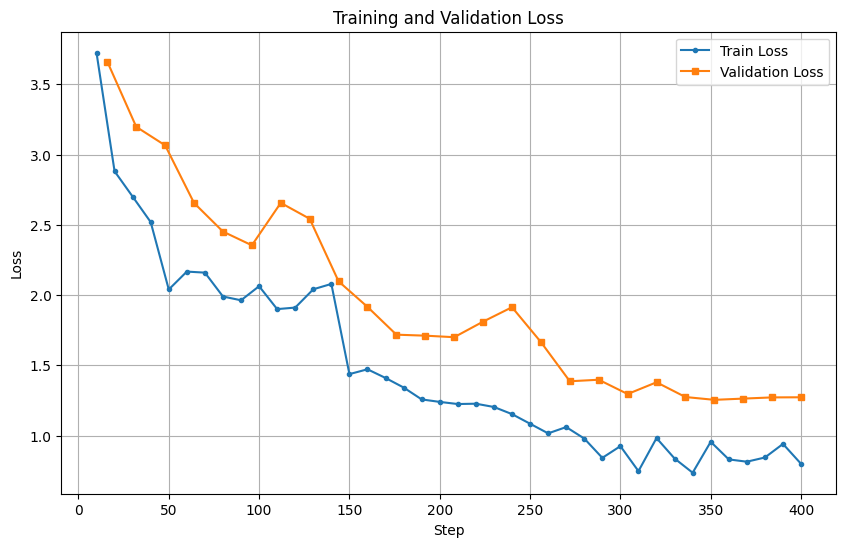

最終トレーニング損失: 0.7985 (Step: 400)
最終バリデーション損失: 1.2722 (Step: 400)
評価回数: 25


In [45]:
import matplotlib.pyplot as plt

# トレーニング履歴を取得
history = trainer.state.log_history

# 損失を抽出（ステップ情報を保持）
train_data = [(log['step'], log['loss']) for log in history if 'loss' in log and 'eval_loss' not in log]
eval_data = [(log['step'], log['eval_loss']) for log in history if 'eval_loss' in log]

# ステップと損失を分離
train_steps = [d[0] for d in train_data]
train_losses = [d[1] for d in train_data]
eval_steps = [d[0] for d in eval_data]
eval_losses = [d[1] for d in eval_data]

# プロット
plt.figure(figsize=(10, 6))
if train_losses:
    plt.plot(train_steps, train_losses, label='Train Loss', marker='o', markersize=3)
if eval_losses:
    plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='s', markersize=5)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

if train_losses:
    print(f"最終トレーニング損失: {train_losses[-1]:.4f} (Step: {train_steps[-1]})")
if eval_losses:
    print(f"最終バリデーション損失: {eval_losses[-1]:.4f} (Step: {eval_steps[-1]})")
    print(f"評価回数: {len(eval_losses)}")

# 風船検知の推論

#

検出数: 2


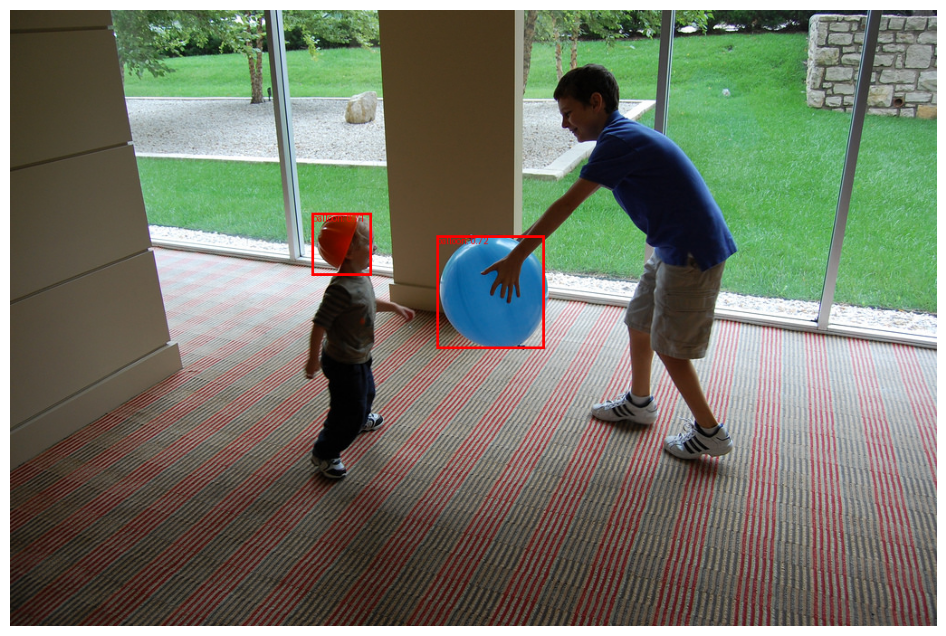

In [44]:
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

# 1. 保存したモデルとプロセッサの読み込み
model_path = "/content/drive/MyDrive/detr_balloon_model"
processor = DetrImageProcessor.from_pretrained(model_path)
model = DetrForObjectDetection.from_pretrained(model_path)

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 2. 推論対象の画像を選択（バリデーションデータから1枚選ぶ例）
# 任意の画像パスに変更可能です
val_img_dir = os.path.join(DATASET_DIR, "balloon", "val")
sample_img_name = os.listdir(val_img_dir)[2] # 最初の一枚
image_path = os.path.join(val_img_dir, sample_img_name)

image = Image.open(image_path).convert("RGB")

# 3. 前処理と推論
inputs = processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# 4. 結果の後処理（しきい値 0.7 以上を検出とする）
# target_sizes は元の画像サイズを指定
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.7)[0] # ここの閾値は重要！

# 5. 可視化
draw = ImageDraw.Draw(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]

    # バウンディングボックスの描画
    draw.rectangle(box, outline="red", width=3)

    # ラベルとスコアの表示
    label_name = model.config.id2label[label.item()]
    text = f"{label_name}: {score:.2f}"
    draw.text((box[0], box[1]), text, fill="red")

print(f"検出数: {len(results['scores'])}")
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

## 補足情報

- **モデル**: `facebook/detr-resnet-50` をベースにファインチューニング
- **データセット**: Balloon Dataset（風船検出）
- **クラス**: 1クラス（balloon）+ 背景クラス
- **データセットサイズ**: 約60枚の画像（トレーニング/バリデーションに分割）
- **チェックポイント**: 各エポック終了時に自動保存
- **ベストモデル**: バリデーション損失が最小のモデルが自動的に保存されます

### 使用方法
1. Google Colabでこのノートブックを開く
2. Runtime > Change runtime type > GPU を選択してGPUを有効化
3. セルを順番に実行する
4. トレーニング完了後、モデルは`outputs/best_model`に保存されます

### 注意事項
- GPUの使用を強く推奨します（CPUでは非常に時間がかかります）
- トレーニングには数時間かかる場合があります
- モデルをGoogle Driveに保存する場合は、12番のセルのコメントアウトを解除してください
